In [2]:
#https://github.com/Kulbear/stock-prediction/blob/master/stock-prediction.ipynb
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Concatenate
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep

Using TensorFlow backend.


In [199]:
def build_model(size, window, num_neurons, out_dim, D = [0.25, 0.25]):
    #Create RNN Branch
    RNN = Sequential()
    #First LSTM Layer
    RNN.add(LSTM(num_neurons[0], input_shape=(window, size), return_sequences = True))
    RNN.add(Activation('tanh'))
    RNN.add(Dropout(D[0]))
    
    #Second LSTM Layer
    RNN.add(LSTM(num_neurons[1], return_sequences=False))
    RNN.add(Activation('tanh'))
    RNN.add(Dropout(D[1]))

    RNN.add(Dense(num_neurons[2]))
    RNN.add(Activation('tanh'))
    
    RNN.add(Dense(out_dim))
    RNN.add(Activation('tanh'))

    start = time.clock()
    RNN.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    print('Compilation Time: ', time.clock() - start)
    return RNN

def preprocess_data(stock, sequence_length, percent_train = 0.9):
    #Normalize data
    stock = np.tanh(stock - stock.mean(axis=0))
    
    num_features = stock.shape[1]
    sequence_length += 1
    
    #Create array of windows
    result = np.zeros((len(stock) - sequence_length, sequence_length, num_features))
    for i in range(len(result)):
        result[i] = (stock[i:i + sequence_length])

    #Use certain percentage of the data for training
    cutoff = int(round(percent_train * len(result)))
    
    #y data is the last row of each window, X data is all other rows
    X_train = result[:cutoff,:-1,:]
    y_train = result[:cutoff,-1,:]
    X_test = result[cutoff:,:-1,:]
    y_test = result[cutoff:,-1,:]

    return [X_train, y_train, X_test, y_test]

def forecast(X, model, time_steps = 20):
    forecast = np.zeros((time_steps, X.shape[2]))
    
    for i in range(time_steps):
        forecast[i] = model.predict(X)[-1]
        s = np.vstack((X[-1,1:], forecast[i]))
        X = np.vstack((X,s[np.newaxis,:,:]))
        
    return forecast

def roll(X, time_steps = 20):
    roll = np.zeros(len(X) - time_steps)
    
    for i in range(len(X) - time_steps):
        roll[i] = np.mean(X[i:i+time_steps])
        
    return roll

In [180]:
data = np.loadtxt('DailyStocks.dat')
#data = np.hstack((data,np.real(np.fft.fft(data)),np.imag(np.fft.fft(data))))

In [181]:
window = 20
X_train, y_train, X_test, y_test = preprocess_data(data, window)
print "X_train:", X_train.shape
print "y_train:", y_train.shape
print "X_test:", X_test.shape
print "y_test:", y_test.shape

X_train: (881, 20, 4)
y_train: (881, 4)
X_test: (98, 20, 4)
y_test: (98, 4)


In [193]:
num_neurons = [128, 128, 128]
num_features = X_train.shape[2]
D = [0.25, 0.25]
model = build_model(num_features, window, num_neurons, num_features, D = D)

('Compilation Time: ', 0.0368829999999889)


In [194]:
start = time.clock()
model.fit(
    X_train,
    y_train,
    batch_size=100,
    epochs=25,
    validation_split=0.2,
    verbose=0)
print time.clock() - start

model.save('RNN_Model.h5')

136.588879


In [195]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.6f MSE (%.6f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.6f MSE (%.6f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.000384 MSE (0.019598 RMSE)
Test Score: 0.000374 MSE (0.019333 RMSE)


In [196]:
import matplotlib.pyplot as plt

alpha = model.predict(X_train)[:,0]

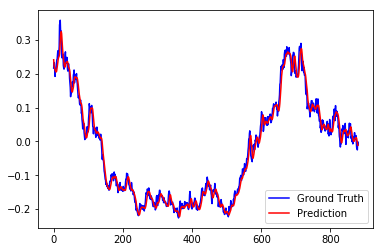

In [197]:
#f = np.zeros(100)
#s = 10
#j = 0
#for i in range(s):
#    f[j:j+s] = forecast(X_test[10*i], model, s)[:,0]
#    j += s
#f = forecast(X_test[0], model, 100)[:,0]
plt.plot(y_train[:,0], 'b', label='Ground Truth')
plt.plot(alpha, 'r', label='Prediction')
#plt.plot(f, 'g', label='Forecast')
plt.legend(loc='best')
plt.show()

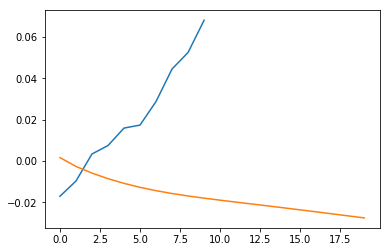

In [166]:
#print model.predict(X_train[-10:])
#print forecast(X_train[-200:-190], model, 10)
plt.plot(y_train[-290:-280,0])
plt.plot(forecast(X_train[-350:-290], model, 20)[:,0])
plt.show()
#print f

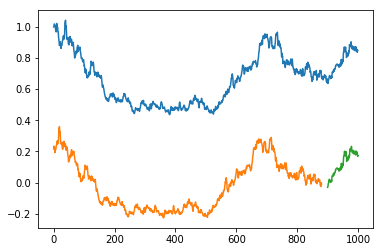

In [198]:
plt.plot(data[:,0])
plt.plot(y_train[:,0])
plt.plot(np.linspace(900,1000,98),y_test[:,0])
plt.show()

In [173]:
print y_train

[[ 0.22056925  0.21477035  0.22365517  0.20625739]
 [ 0.23754111  0.23537434  0.24199729  0.23416406]
 [ 0.23548827  0.23382578  0.23861135  0.22949243]
 ..., 
 [-0.02514881 -0.02051185 -0.01955006 -0.03248101]
 [-0.00079068  0.0006086   0.00278363 -0.0050794 ]
 [-0.00912451 -0.00607405 -0.00264588 -0.01048438]]


In [170]:
(np.tanh(data) - np.tanh(data).mean()).mean()

8.5265128291212024e-17

In [186]:
print X_train.mean()

-0.0172575844586
